### **Import** **Module**

In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

# **Load the Dataset**

In [20]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [21]:
!kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [22]:
BASE_DIR = '/content/UTKFace'

In [23]:
# labels --> age , gender, ethinicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
  image_path = os.path.join(BASE_DIR, filename)
  temp = filename.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [24]:
# Convert to the dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/23_1_0_20170103180703224.jpg....,23,1
1,/content/UTKFace/26_1_1_20170116183008326.jpg....,26,1
2,/content/UTKFace/26_1_2_20170117174716222.jpg....,26,1
3,/content/UTKFace/47_1_3_20170109133358794.jpg....,47,1
4,/content/UTKFace/50_1_0_20170111182452949.jpg....,50,1


In [25]:
# Map Labels for Gender
gender_dict = {0:'Male', 1:'Female'}

# **Explolatory Data Analysis**

In [26]:
from PIL import Image

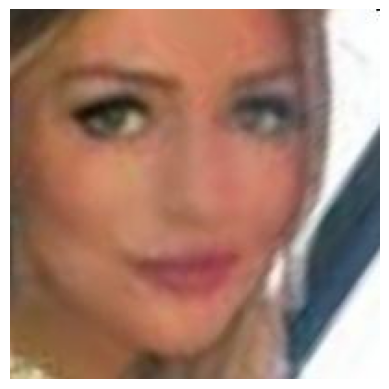

In [27]:
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

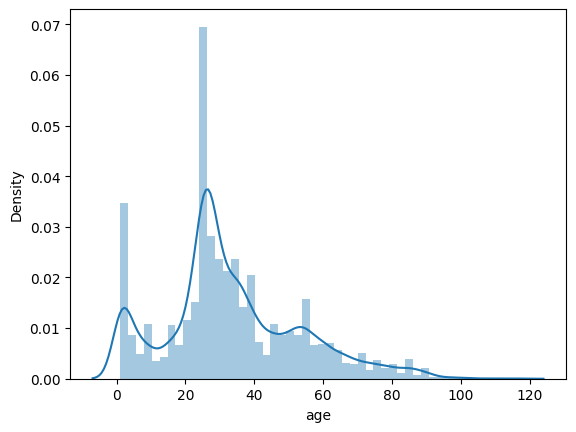

In [28]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

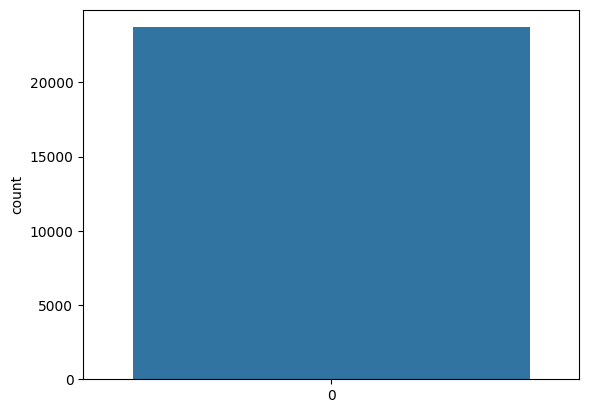

In [31]:
sns.countplot(df['gender'])

In [35]:
# To Display Grid of Images
plt.figure(figsize=(20,20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title(f"Age: {age}  Gender: {gender_dict[gender]}")
  plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

# **Feature Extraction**

In [36]:
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  # Ignore this step if using RGB
  features = features.reshape(len(features), 128, 128, 1)
  return features

In [37]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [38]:
X.shape

(23708, 128, 128, 1)

In [39]:
# Normalise the Images
X = X/255.0

In [40]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [41]:
input_shape = (128, 128, 1)

# **Model Creation**

In [43]:
inputs = Input((input_shape))
# Convolutional Layers
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten() (maxp_4)

# Fully Connected Layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])


In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 126, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_4[0][0]']               
                                                                                              

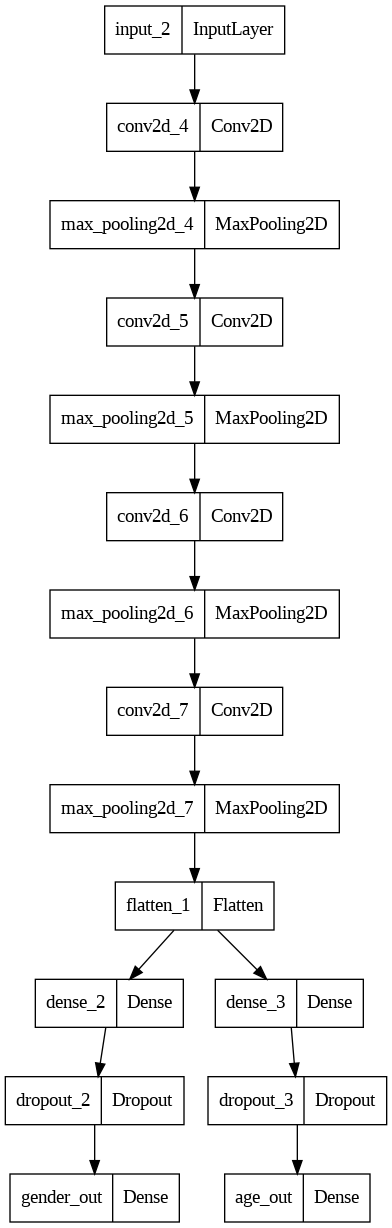

In [45]:
# Plot the Model
from tensorflow.keras.utils import plot_model
plot_model(model)

# **Train the Model**

In [46]:
history = model.fit(x=X,y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 28s 22ms/step - loss: 15.5151 - gender_out_loss: 0.6641 - age_out_loss: 14.8510 - gender_out_accuracy: 0.5703 - age_out_accuracy: 0.0463 - val_loss: 13.3297 - val_gender_out_loss: 0.5440 - val_age_out_loss: 12.7857 - val_gender_out_accuracy: 0.7337 - val_age_out_accuracy: 0.0456
Epoch 2/30
593/593 [==============================] - 11s 19ms/step - loss: 11.6255 - gender_out_loss: 0.4837 - age_out_loss: 11.1419 - gender_out_accuracy: 0.7706 - age_out_accuracy: 0.0257 - val_loss: 10.1449 - val_gender_out_loss: 0.4284 - val_age_out_loss: 9.7164 - val_gender_out_accuracy: 0.7982 - val_age_out_accuracy: 0.0116
Epoch 3/30
593/593 [==============================] - 12s 21ms/step - loss: 10.0017 - gender_out_loss: 0.4134 - age_out_loss: 9.5883 - gender_out_accuracy: 0.8093 - age_out_accuracy: 0.0144 - val_loss: 9.1273 - val_gender_out_loss: 0.3654 - val_age_out_loss: 8.7619 - val_gender_out_accuracy: 0.8307 - val_age_out_accuracy: 0.0036
Ep

# **Plot the Results**

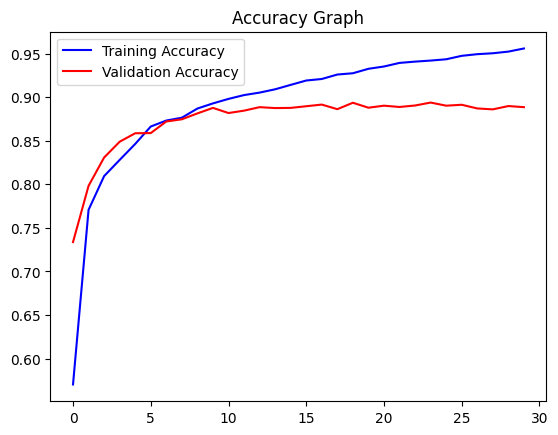

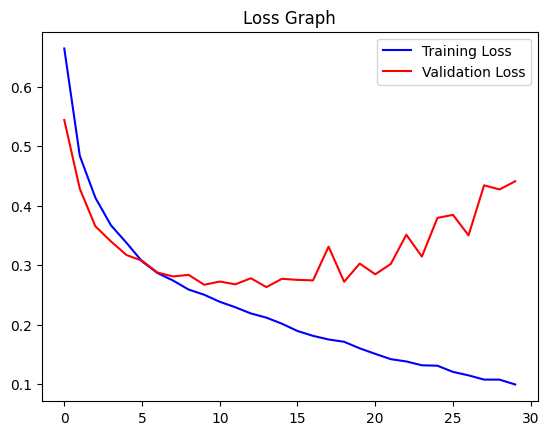

In [47]:
# Plot Results for Gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

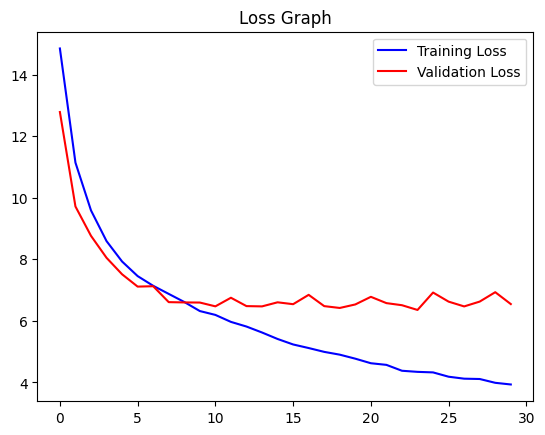

In [48]:
# Plot Results for Age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# **Prediction with Test Data**

Original Gender: Female Original Age: 23
1/1 [==============================] - 0s 33ms/step
Predicted Gender: Female Predicted Age: 22


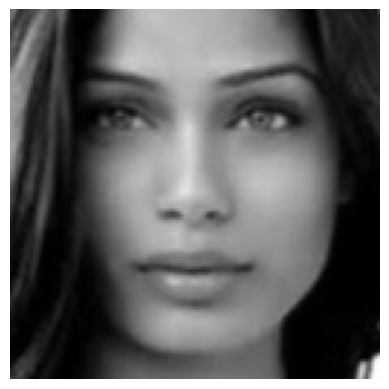

In [50]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# Predict from Model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender,"Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray');

Original Gender: Male Original Age: 26
1/1 [==============================] - 0s 28ms/step
Predicted Gender: Male Predicted Age: 22


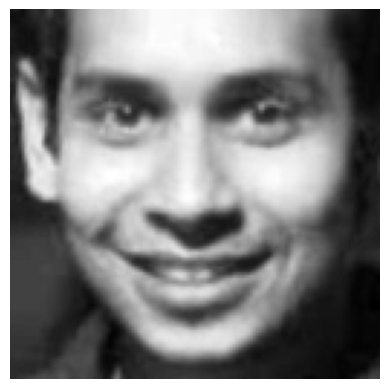

In [51]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# Predict from Model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender,"Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray');

Original Gender: Female Original Age: 24
1/1 [==============================] - 0s 97ms/step
Predicted Gender: Female Predicted Age: 23


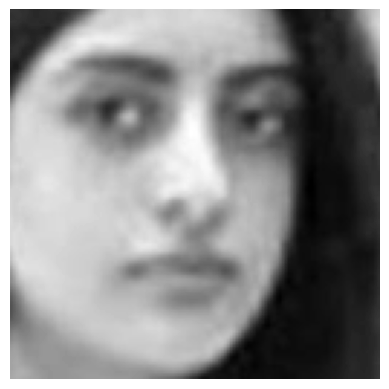

In [52]:
image_index = 5000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# Predict from Model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender,"Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray');

Original Gender: Female Original Age: 59
1/1 [==============================] - 0s 29ms/step
Predicted Gender: Female Predicted Age: 56


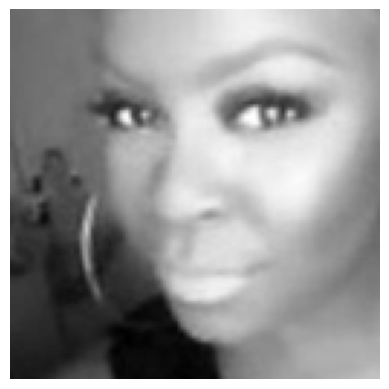

In [53]:
image_index = 2714
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# Predict from Model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender,"Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray');